# Predicting DC Homicides
## A Capstone Project for Udacity's Machine Learning Engineer Nanodegree


## Loading Data

First, we will load the packages for this exploration, along with the dataset, printing the first 5 observations to get an idea of what our dataset looks like. Since we're doing a categorical prediction with a decision tree, normalizing our data shouldn't be as important as if we were, say, predicting the *number* of homicides predicted per street through a regression-type analysis.

In [18]:
#Import packages
import pandas as pd
import numpy as np
from collections import Counter
from __future__ import division 
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xgboost as xgb
import seaborn as sns
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#Load dataset
data = pd.read_csv("FINAL_DATASET.csv")
data.head()

,Street Segment,SHAPELEN,District_1,District_2,District_3,District_4,District_5,District_6,District_7,METRO_BLUESILVER,...,PUBLICSCHOOL_MS_ONEHOT,PUBLICSCHOOL_HS_ONEHOT,FEDERAL_ONEHOT,CORRIDOR_ONEHOT,FAGI_MEDIAN_2015,FAGI_MEDIAN_CHANGE,POPDENSITY,HOUSINGDENSITY,PERCVACANTHOUSING,HOMICIDES_ONEHOT
0,1,180.26104,0,0,0,0,0,0,1,0,...,0,0,0,0,22943.75,0.974211,10268.537840,4566.558530,0.157097,0
1,2,195.02022,0,0,0,0,0,0,1,0,...,0,0,1,0,23679.00,1.040104,7344.806172,2850.099631,0.129360,1
2,3,109.59528,1,0,0,0,0,0,0,0,...,0,0,1,0,58798.50,1.257184,4122.550303,2018.944963,0.066684,0
3,4,23.02183,0,0,1,0,1,0,0,0,...,0,0,1,0,54693.00,1.346452,21876.121930,11944.374240,0.111143,0
4,5,70.40390,0,0,0,0,1,0,0,0,...,0,0,1,0,51879.25,1.276225,12226.236930,5291.997504,0.117610,0


## Exploratory Data Analysis

Next, we'll compute some basic statistics on homicides over the features on which we're predicting: DC's street segments. It appears less than 8% of DC street segements experienced a homicide between 1 January 2008 and 31 October 2017, meaning our homicide observations are sparse. Decision trees typically perform well on sparse data, lending greater credence to my choice of a boosted decision tree to predicti which streets are likely to have experienced homicides over this period.

In [2]:
#Compute basic statistics on streets and homicide occurence
n_streets = len(data)
c = Counter(data["HOMICIDES_ONEHOT"])
n_homicides = c[1]
homicides_percent = ((n_homicides) / (n_streets)) * 100

print ("Total number of streets in DC: {}".format(n_streets))
print ("Total number of DC streets where homicide occured between January 2008 and October 2017: {}".format(n_homicides))
print ("Percentage of DC streets homicide occured between January 2008 and October 2017: {:.2f}%".format(homicides_percent))

Total number of streets in DC: 13664
Total number of DC streets where homicide occured between January 2008 and October 2017: 987
Percentage of DC streets homicide occured between January 2008 and October 2017: 7.22%


I wanted to make sure my features were independent, so I printed a heatmap of correlations across features. Feature independence is important for trees as the splits within the tree predicting variance in the label can be attributed to one feature with a higher level of confidence than with highly-correlated features. Certain metrolines were highly positively locationally correlated, which made sense as several lines share a majority of their tracks within DC's borders. Population and housing density were also similarly positively correlated, and median federally adjusted gross income (FAGI) by cesus tract in 2015 was also positively correlated with District 2, the historically White, upper-class neighrhoods in DC West of Rock Creek Park, though to a weaker segree than other highly-positive correlations. On the other hand, District 2 was negatively correlated with the percentage of total housing vacant, whereas Districts 6 and 7 in Anacostia, the most underserved part of DC, were negatively correlated with both 2015 FAGI and the change in FAGI from 2010 to 2015, perhaps reflecting both the challenges of a slow working class and minority recovery from the 2008 financial crisis and systemic barriers uniquely preventing gentrification of neighborhoods East of the Anacostia River. Unsurprisingly, 2015 FAGI was also strongly negatively correlated with the percentage of total housing vacant. Overall, the data appears fairly weakly correlated, which should give us good decision trees for our analysis.

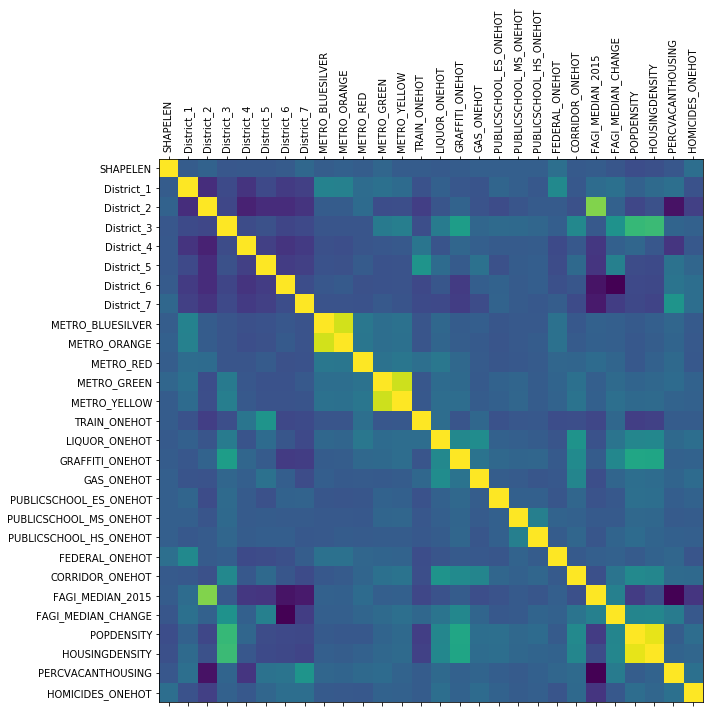

In [3]:
# Visualize correlation of features and streets where homicides occured
corrdata = data.drop(data.columns[0], axis=1)

corr = corrdata.corr()
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
plt.yticks(range(len(corr.columns)), corr.columns);            

Continuing our exploratory analysis, I found that street proximity to a liquor store, 2015 FAGI and the percentage of total housing vacant within the street's census tract, and location of a street in either District 2 or District 7 were all correlated at or above 0.1 with the incidence of at least one homicide between 2007 and 2017. These factors are likely to play a significant role in predicting whether homicides occured on any given street in DC within our timeframe.

In [4]:
# Calculate correlation scores for most-correlated variables with homicide
corrdata.corr()

,SHAPELEN,District_1,District_2,District_3,District_4,District_5,District_6,District_7,METRO_BLUESILVER,METRO_ORANGE,...,PUBLICSCHOOL_MS_ONEHOT,PUBLICSCHOOL_HS_ONEHOT,FEDERAL_ONEHOT,CORRIDOR_ONEHOT,FAGI_MEDIAN_2015,FAGI_MEDIAN_CHANGE,POPDENSITY,HOUSINGDENSITY,PERCVACANTHOUSING,HOMICIDES_ONEHOT
SHAPELEN,1.000000,0.002208,0.031514,-0.024746,-0.020627,-0.019289,-0.003570,0.060920,0.003477,0.023830,...,0.015753,0.015639,0.105853,-0.009684,-0.000795,-0.034265,-0.077189,-0.067644,-0.024327,0.098937
District_1,0.002208,1.000000,-0.225552,-0.090862,-0.199390,-0.099691,-0.165604,-0.141325,0.213330,0.207347,...,0.016658,-0.019984,0.259621,-0.019315,0.086844,0.109955,0.026415,0.077456,0.105144,-0.055526
District_2,0.031514,-0.225552,1.000000,-0.110365,-0.272642,-0.228889,-0.231698,-0.200019,0.002022,-0.000996,...,-0.035423,-0.006016,-0.004556,-0.059890,0.732923,0.027404,-0.112199,-0.057603,-0.343319,-0.141288
District_3,-0.024746,-0.090862,-0.110365,1.000000,-0.080657,-0.058461,-0.113670,-0.098128,-0.037436,-0.038226,...,0.073592,0.054767,0.011090,0.250963,-0.017347,0.311576,0.532573,0.548981,0.045846,0.030325
District_4,-0.020627,-0.199390,-0.272642,-0.080657,1.000000,-0.144945,-0.196025,-0.169223,-0.068077,-0.069375,...,-0.007065,-0.000460,-0.095253,-0.022599,-0.180269,0.022048,0.056852,-0.026546,-0.190897,-0.021895
District_5,-0.019289,-0.099691,-0.228889,-0.058461,-0.144945,1.000000,-0.160775,-0.139846,-0.056259,-0.057332,...,0.001096,0.010622,-0.084560,0.074377,-0.189393,0.202377,-0.080863,-0.093299,0.119193,0.053155
District_6,-0.003570,-0.165604,-0.231698,-0.113670,-0.196025,-0.160775,1.000000,-0.076734,-0.024915,-0.011598,...,-0.003332,0.013380,-0.067994,-0.030449,-0.337269,-0.409520,-0.099419,-0.102801,0.131685,0.098285
District_7,0.060920,-0.141325,-0.200019,-0.098128,-0.169223,-0.139846,-0.076734,1.000000,-0.049163,-0.050100,...,-0.005521,-0.022282,0.006598,-0.088675,-0.307374,-0.154546,-0.104802,-0.122215,0.317320,0.100296
METRO_BLUESILVER,0.003477,0.213330,0.002022,-0.037436,-0.068077,-0.056259,-0.024915,-0.049163,1.000000,0.901924,...,-0.017990,-0.015785,0.115298,-0.018835,0.030709,0.017124,-0.013054,0.014602,0.053648,-0.010541
METRO_ORANGE,0.023830,0.207347,-0.000996,-0.038226,-0.069375,-0.057332,-0.011598,-0.050100,0.901924,1.000000,...,-0.018333,-0.001981,0.113749,-0.003991,0.024757,0.015359,-0.020054,0.007091,0.042324,-0.013819


In [5]:
# Separate features from labels
features = data.drop('HOMICIDES_ONEHOT', axis = 1)
label = data['HOMICIDES_ONEHOT']

# Separate into training and testing sets
X_analysis, X_test, y_analysis, y_test = train_test_split(features, label, test_size = 0.3, random_state = 57)
print ("Cumulative training set has {} samples.".format(X_analysis.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Cumulative training set has 9564 samples.
Testing set has 4100 samples.


In [6]:
# Further separate into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_analysis, y_analysis, test_size=0.2, random_state=57)
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))

Training set has 7651 samples.
Validation set has 1913 samples.


In [7]:
# Naive predictor or baseline model

In [8]:
# Initital paramenters courtesy of Jesse Steinweg-Woods, Ph.D. in 
## "A Guide to Gradient Boosted Trees with XGBoost in Python"
## https://jessesw.com/XG-Boost/

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'f1', cv = 5, n_jobs = -1)

optimized_GBM.fit(X_train, y_train)

/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [9]:
# Check grid scores
optimized_GBM.grid_scores_

[mean: 0.13451, std: 0.01953, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.16551, std: 0.02418, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.14999, std: 0.03739, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.14026, std: 0.01039, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.14778, std: 0.01927, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.16428, std: 0.03040, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.14140, std: 0.02193, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.14921, std: 0.03695, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.14401, std: 0.01896, params: {'max_depth': 7, 'min_child_weight': 5}]

In [10]:
cv_params = {'learning_rate': [0.1, 0.5, 0.01], 'subsample': [0.7, 0.8, 0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 3}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'f1', cv = 5, n_jobs = -1)

optimized_GBM.fit(X_train, y_train)

/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.5, 0.01], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [11]:
optimized_GBM.grid_scores_

[mean: 0.14491, std: 0.02987, params: {'learning_rate': 0.1, 'subsample': 0.7},
 mean: 0.16551, std: 0.02418, params: {'learning_rate': 0.1, 'subsample': 0.8},
 mean: 0.14875, std: 0.02024, params: {'learning_rate': 0.1, 'subsample': 0.9},
 mean: 0.19044, std: 0.02093, params: {'learning_rate': 0.5, 'subsample': 0.7},
 mean: 0.17493, std: 0.02606, params: {'learning_rate': 0.5, 'subsample': 0.8},
 mean: 0.18698, std: 0.01261, params: {'learning_rate': 0.5, 'subsample': 0.9},
 mean: 0.04816, std: 0.01984, params: {'learning_rate': 0.01, 'subsample': 0.7},
 mean: 0.04168, std: 0.02321, params: {'learning_rate': 0.01, 'subsample': 0.8},
 mean: 0.03488, std: 0.02164, params: {'learning_rate': 0.01, 'subsample': 0.9}]

In [12]:
# Create DMatrix
xgdmat = xgb.DMatrix(X_train, y_train)

In [13]:
# Make predictions with model
optimized_params = {'eta': 0.05, 'seed':0, 'subsample': 0.7, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':3}
final_model = xgb.train(optimized_params, xgdmat)

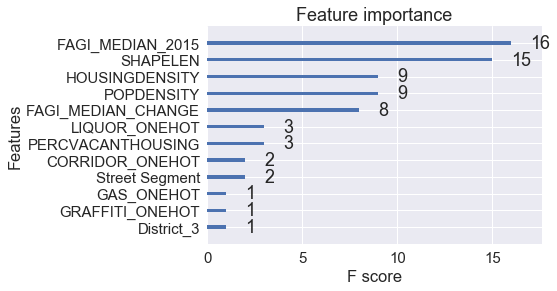

In [14]:
sns.set(font_scale = 1.5)

xgb.plot_importance(final_model)

In [21]:
testdmat = xgb.DMatrix(X_test, y_test)
y_pred = final_model.predict(testdmat)
print(y_pred)
y_pred_yes = final_model.predict(testdmat)
y_pred_yes[y_pred > 0.5] = 1
y_pred_yes[y_pred <= 0.5] = 0
print(y_pred_yes)

[0.30607232 0.38668656 0.31233716 ... 0.3105539  0.40529126 0.30607232]
[0. 0. 0. ... 0. 0. 0.]


In [25]:
finalf1 = f1_score(y_test, y_pred_yes, labels=None) 
print ("F1 score on final test data: {}".format(finalf1))

F1 score on final test data: 0.0


/anaconda2/envs/homicides/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
## TO DO: Use final model to predict probability of homicide on each street and 
## append to data as "Pred_likelihood_of_homicide" column


In [ ]:
# TO DO: Compare to F1 of baseline models